# Exploring the differences between medicinal and non medicinal plants using chemical classes

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# PCA
from sklearn.decomposition import PCA

# T-SNE
from openTSNE import TSNE

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load plant-chemical and plant-disease associations

In [4]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

In [5]:
plant_disease_df.head(1)

,plant_curie,plant_name,disease_curie,database,evidence
0,ncbitaxon:3369,Cryptomeria japonica,mondo:0005324,bern2,10067319_8


Medicinal plants

In [6]:
medicinal_plants = plant_disease_df.plant_curie.unique()

Load chemicals

In [7]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [8]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [9]:
len(plant_chemical_df.chemical_curie.unique())

71179

### Annontate medicinal and non-medicinal plants

In [10]:
plant_chemical_df['plant_type'] = plant_chemical_df['plant_curie'].progress_map(
    lambda x: 'Medicinal' if x in medicinal_plants else 'Non-medicinal'
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 330655/330655 [00:57<00:00, 5711.77it/s]


In [11]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


### Extract chemical classes

Load ClassyFire classes

In [12]:
classyfire_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/classyfire_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'smiles',
        'class.name'
    ],
    index_col='smiles'
).to_dict()['class.name']

In [13]:
len(classyfire_dict)

64321

Load NPClassifier classes

In [14]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [15]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [16]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [17]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 323369/323369 [00:00<00:00, 424016.09it/s]


In [18]:
classyfire_dict = {
    smiles_to_pubchem[smile]: classes
    for smile, classes in classyfire_dict.items()
    if smile in smiles_to_pubchem
}
len(classyfire_dict)

1644

In [19]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

37859

### Compound class annotation

In [20]:
classyfire_annotated_plants = plant_chemical_df.copy(deep=True)
classyfire_annotated_plants['class'] = classyfire_annotated_plants['chemical_curie'].map(classyfire_dict)

In [21]:
# all plants
classyfire_annotated_plants.shape

(330655, 4)

In [22]:
classyfire_annotated_plants.dropna(subset=['class'], inplace=True)

In [23]:
classyfire_annotated_plants.shape

(11605, 4)

In [24]:
classyfire_annotated_plants['plant_type'].value_counts()

Medicinal        7169
Non-medicinal    4436
Name: plant_type, dtype: int64

In [25]:
classyfire_annotated_plants['class'].value_counts()

Prenol lipids                               2909
Fatty Acyls                                 2649
Saturated hydrocarbons                      1564
Organooxygen compounds                      1499
Benzene and substituted derivatives          615
                                            ... 
Oxolanes                                       1
Organic phosphoric acids and derivatives       1
Organobromides                                 1
Organic sulfonic acids and derivatives         1
Organic sulfuric acids and derivatives         1
Name: class, Length: 82, dtype: int64

In [26]:
np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

In [27]:
# all plants
np_classifier_annotated_plants.shape

(357412, 4)

In [28]:
np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

In [29]:
np_classifier_annotated_plants.shape

(251717, 4)

In [30]:
np_classifier_annotated_plants['plant_type'].value_counts()

Non-medicinal    131355
Medicinal        120362
Name: plant_type, dtype: int64

In [31]:
np_classifier_annotated_plants['class'].value_counts()

Flavonols                         18854
Flavones                          12019
Cinnamic acids and derivatives     8380
Oleanane triterpenoids             6853
Simple phenolic acids              6469
                                  ...  
Cephamycins                           1
Other Docosanoids                     1
Isoaurones                            1
Griseofulvins                         1
Thia fatty acids                      1
Name: class, Length: 524, dtype: int64

### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [32]:
def create_np_classifier_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated NP-Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)
    

def create_classyfire_vectors(df: pd.DataFrame):
    all_classes = set(df['class'].unique())
    plants = set(df['plant_curie'].unique())
    
    vector_data = []
    
    for plant_name in tqdm(plants, desc='Generated Classifier vectors'):
        phytochem_df = df[df['plant_curie'] == plant_name]
        
        t = {
            'plant_name': plant_name,
        }
        
        for class_name in all_classes:
            temp = phytochem_df[phytochem_df['class'] == class_name]
            t[class_name] = len(temp['chemical_curie'].unique())
        
        vector_data.append(t)
            
    return pd.DataFrame(vector_data)

In [33]:
plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)

Generated NP-Classifier vectors: 100%|█████████████████████████████████████████████████████████████████████████████| 15859/15859 [53:40<00:00,  4.92it/s]


In [34]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Jasmonic acids,Ansa peptide alkaloids,Acutumine alkaloids,Carboline alkaloids,Pinguisane sesquiterpenoids,Other Docosanoids,Oligomeric stibenes,Simple indole alkaloids,Spirovetivane sesquiterpenoids,Pregnane steroids,Colensane and Clerodane diterpenoids,Marasmane sesquiterpenoids,Triacylglycerols,"Carotenoids (C40, κ-κ)",Naphthoquinones,Epoxy fatty acids,Hydrocarbons,Selaginellins,Quadrane sesquiterpenoids,Capsaicins and Capsaicinoids,Microcystins,Streptogramins,Isocoumarins,Aminosugars,Sphenolobane diterpenoids,Isoprostanes,Secochamigrane sesquiterpenoids,Verrucosane diterpenoids,Miscellaneous polyketides,Bisnaphthalenes,Dolabellane diterpenoids,Ceramides,Thujane monoterpenoids,Abeolupane triterpenoids,Anabaenopeptins,Simple cyclic polyketides,Polyprenylated cyclic polyketides (Hop meroterpenoids),Meromonoterpenoids,Oppositane sesquiterpenoids,Anthocyanidins,Norlabdane diterpenoids,m-Terphenyls,Menthane monoterpenoids,Guanacastane diterpenoids,Protopine alkaloids,Asteriscane sesquiterpenoids,Marine-bacterial DPEs,Dialkylresorcinols,Iboga type,Diacylglycerols,Tetraketide meroterpenoids,Parguerane diterpenoids,Biaryl type diarylheptanoids,Angucyclines,Labdane diterpenoids,Cuparane sesquiterpenoids,Serratane triterpenoids,Cheilanthane sesterterpenoids,Phenethylisoquinoline alkaloids,Irregular monoterpenoids,Glycerophosphoglycerophosphoglycerols,Elemane sesquiterpenoids,Secogermacrane sesquiterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Ala)",Fusicoccane diterpenoids,Prezizaane sesquiterpenoids,Flavones,Pimarane and Isopimarane diterpenoids,Phenoxazine alkaloids,Fatty acyl glycosides of mono- and disaccharides,Megastigmanes,Indole-Diterpenoid alkaloids (Penitrems),Furans,Perforane sesquiterpenoids,Valerane sesquiterpenoids,Erythromycins,Glucosinolates,Scalarane sesterterpenoids,Tripeptides,Dipeptides,Naphthalenes and derivatives,Thiodiketopiperazine alkaloids,Acorane sesquiterpenoids,Bourbonane sesquiterpenoids,Flavonostilbenes,Homoerythrina alkaloids,Secokaurane diterpenoids,Dunniane sesquiterpenoids,Illudalane sesquiterpenoids,Pachysanane triterpenoids,Strychnos type,Oxasqualenoids,Oxo fatty acids,Acridone alkaloids,Friedelane triterpenoids,Thapsane sesquiterpenoids,"Prenylated,geranylated phloroglucinols",Flavan-3-ols,Aromadendrane sesquiterpenoids,Vitamin D2 and derivatives,Humbertiane sesquiterpenoids,Carbapenems,Carbocyclic fatty acids,Cephamycins,Ahp-containing cyclodepsipeptides,Spirostane steroids,Plant xanthones,Bactoprenols,Jatropholane diterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Cinnamoyl phenols,Rhamnolipids,Indolizidine alkaloids,Simple diketopiperazine alkaloids,Tylosins,Resin glycosides,Streptothricins and derivatives,Shionane triterpenoids,"Lanostane, Tirucallane and Euphane triterpenoids",Aphidicolane diterpenoids,Quinolizidine alkaloids,Gorgonane sesquiterpenoids,Spriromeroterpenoids,Arylnaphthalene and aryltetralin lignans,Simple oxindole alkaloids,Griseofulvins,Anthraquinones and anthrones,Simple coumarins,Simple amide alkaloids,Lactarane sesquiterpenoids,Aplysiatoxins,Cyclitols,Polyether ionophores,Quassinoids,Acidic glycosphingolipids,Gammacerane triterpenoids,Decalins with 2-pyrones,Copacamphane sesquiterpenoids,Phytane diterpenoids,Androstane steroids,Neutral glycosphingolipids,Open-chain polyketides,Phloroglucinol-terpene hybrids,Ergostane steroids,Depsides,Triketide meroterpenoids,Cadinane sesquiterpenoids,Monomeric stilbenes,Abeoabietane diterpenoids,Furanoabietane diterpenoids,Glycosyldiacylglycerols,Bergamotane sesquiterpenoids,"Carotenoids (C40, ε-Ψ)",Dimeric phloroglucinols,Antimycins,Pseudopterane diterpenoids,Himachalane sesquiterpenoids,Tigliane diterpenoids,Rotundane sesquiterpenoids,Flavonolignans,Coumaronochromones,Benzodiazepine alkaloids,Laurane sesquiterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Ishwarane sesquiterpenoids,Phenylethanoids,Pyrrolidine alkaloids,Lipopeptides,Camphane monoterpenoids,Fukinane sesquiterpenoids,Halogenated hydrocarb

In [35]:
plant_to_classyfire_vectors = create_classyfire_vectors(classyfire_annotated_plants)

Generated Classifier vectors: 100%|██████████████████████████████████████████████████████████████████████████████████| 2978/2978 [01:32<00:00, 32.11it/s]


In [36]:
plant_to_classyfire_vectors.head(2)

,plant_name,Organic disulfides,Sulfonyls,Pyrroles,Quinolines and derivatives,Tetrathianes,Oxanes,Pyrrolines,Azepanes,Pyrrolizidines,Phenols,Organic phosphines and derivatives,Organic sulfonic acids and derivatives,Dioxanes,Pyrrolidines,Organobromides,Allyl sulfur compounds,Piperidines,Organometalloid compounds,Benzopyrans,Tetrahydroisoquinolines,Organoiodides,Dithiins,Coumarins and derivatives,Cinnamaldehydes,Thiols,Naphthalenes,Macrolactams,Benzimidazoles,Sulfinyl compounds,Epoxides,Dithianes,Prenol lipids,Unsaturated hydrocarbons,Organic phosphoric acids and derivatives,Organic sulfuric acids and derivatives,Tetralins,Sulfoxides,Organic trisulfides,Furans,Dihydrofurans,"3,4-dihydrocoumarins",Thioacetals,Organooxygen compounds,Carboxylic acids and derivatives,Isothiocyanates,Saturated hydrocarbons,Tropane alkaloids,Azolidines,Hydroxy acids and derivatives,Pyrans,Benzopyrazoles,Trithianes,Azoles,Benzothiazoles,Thiophenes,Tetrahydrofurans,Isocoumarins and derivatives,Benzene and substituted derivatives,Lactones,Keto acids and derivatives,Thiosulfinic acid esters,Phenol ethers,Phenalenes,Oxolanes,Organic dithiophosphoric acids and derivatives,Diazines,Indoles and derivatives,Heteroaromatic compounds,Imidazopyrimidines,Glycerolipids,Tropones,Thioethers,Oxazinanes,Benzoxazines,Polycyclic hydrocarbons,Cinnamic acids and derivatives,Diazanaphthalenes,Dithiolanes,Fatty Acyls,Sulfenyl compounds,Pyridines and derivatives,Organonitrogen compounds
0,ncbitaxon:1885667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:53883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Collapsing plant species to plant families

In [37]:
_, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16857/16857 [00:00<00:00, 27372.68it/s]


In [38]:
def get_familiy_stats():
    
    family_data = []
    
    for family_name in tqdm(family_to_species):
        tmp = plant_chemical_df[plant_chemical_df['plant_curie'].isin(family_to_species[family_name])]
        val_counts = tmp['plant_type'].value_counts().to_dict()
        
        for plant_type, plant_count in val_counts.items():
            family_data.append({
                'family': family_name,
                'plant_count': plant_count,
                'plant_type': plant_type
            })
        
    df = pd.DataFrame(family_data)
    df.set_index('family', inplace=True)
    df.fillna(0, inplace=True)
    
    g = sns.displot(
        data=df,
        x='plant_count',
        hue='plant_type',
        stat="percent",
        kde=True,
        common_norm=False,
        height=4,
        aspect=1.5,
        bins=1000,
        alpha=0.7,
        palette={
            'Medicinal': '#f4b183',
            'Non-medicinal': '#2dea99',
        },
    )

    g.set(xlim=(-1, 1000))

    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:06<00:00, 72.67it/s]


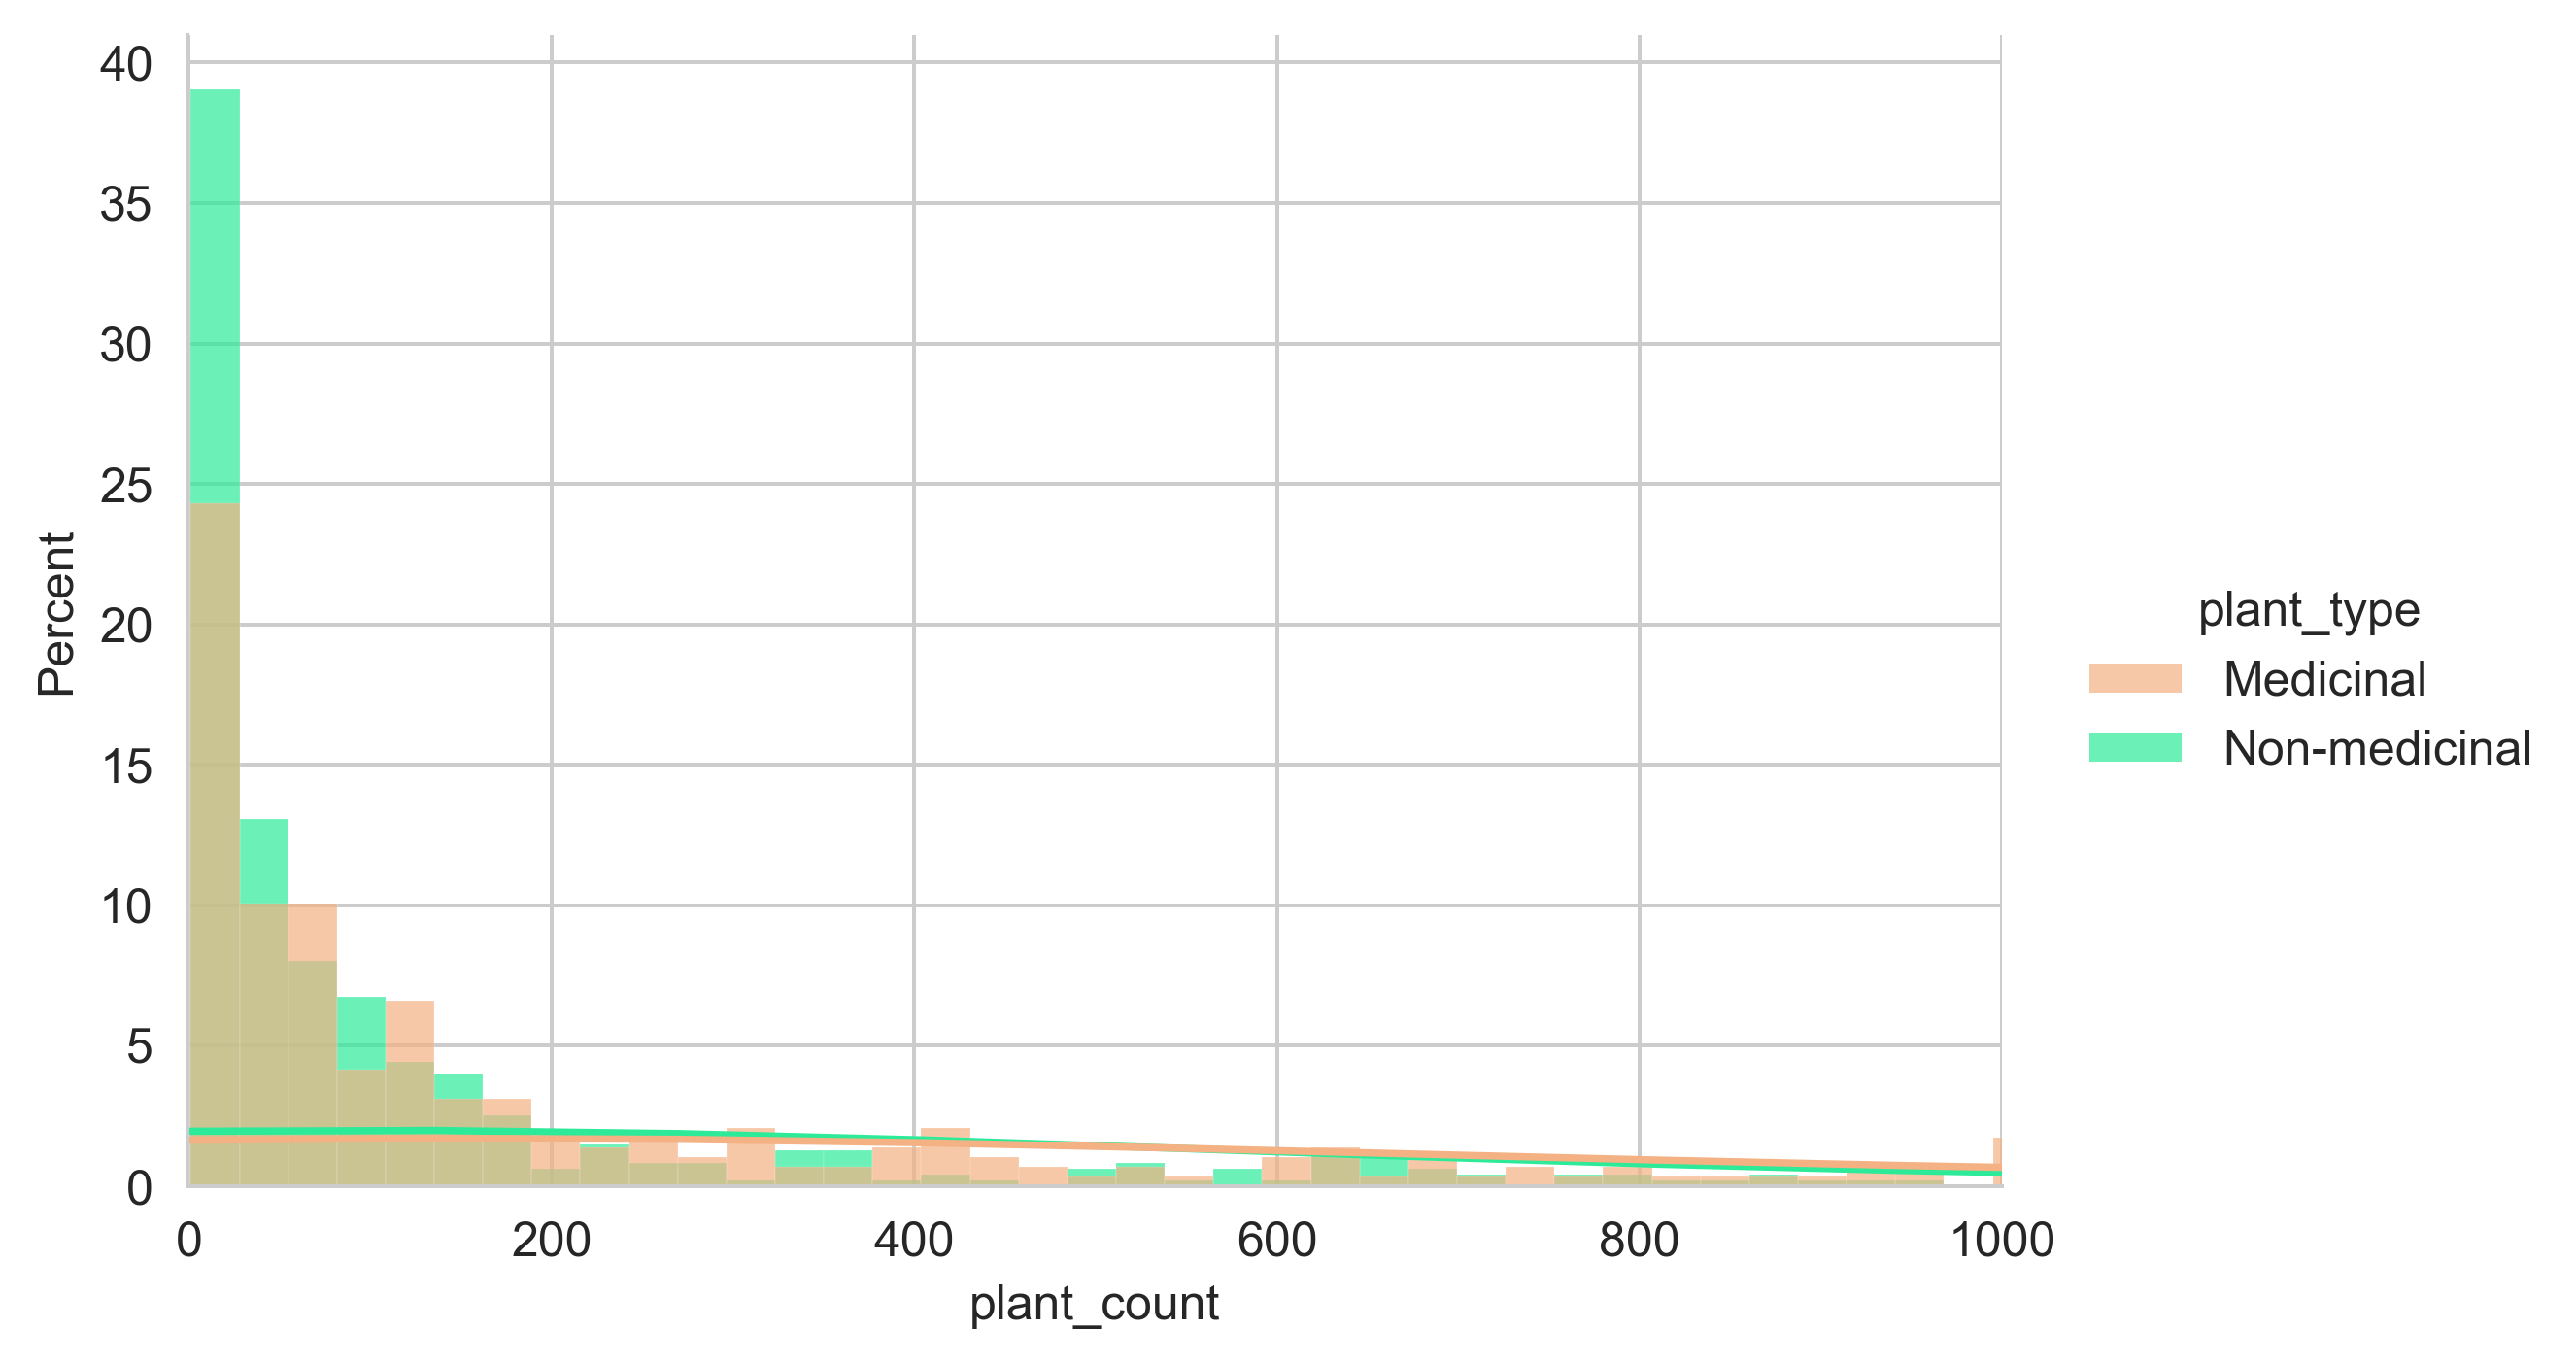

In [39]:
get_familiy_stats()

In [40]:
def collapse_to_family(df: pd.DataFrame):
    
    data = []
    skipped_empty = 0
    skipped_med = 0
    skipped_non_med = 0
    
    # Medicinal flag mapping
    k = plant_chemical_df[['plant_curie', 'plant_type']]
    k.set_index('plant_curie', inplace=True)
    mapper = k.to_dict()['plant_type']
    df['plant_type'] = df['plant_name'].map(mapper)
    
    for family_curie in tqdm(family_to_species):
        tmp_df = df[df['plant_name'].isin(family_to_species[family_curie])]
        
        if tmp_df.empty:
            skipped_empty +=1
            continue
            
        tmp_df = tmp_df.drop(columns=['plant_name'])
        
        med_df = tmp_df[tmp_df['plant_type'] == 'Medicinal']
        med_df = med_df.drop(columns=['plant_type'])
        
        # Remove family pairs with chemical class less than 10
        if med_df.sum().sum() < 10:
            skipped_med +=1
            continue
        
        med_dict = med_df.sum().to_dict()
        med_dict['family'] = family_curie
        med_dict['ftype'] = 'Medicinal'
        
        non_med_df = tmp_df[tmp_df['plant_type'] == 'Non-medicinal']
        non_med_df = non_med_df.drop(columns=['plant_type'])
        
        # Remove family pairs with chemical class less than 10
        if non_med_df.sum().sum() < 10:
            skipped_non_med +=1
            continue
        
        non_med_dict = non_med_df.sum().to_dict()
        non_med_dict['family'] = family_curie
        non_med_dict['ftype'] = 'Non-medicinal'
        
        data.append(med_dict)
        data.append(non_med_dict)

    print('Empty skipped -', skipped_empty)
    print('Medicinal skipped -', skipped_med)
    print('Non-medicinal skipped -', skipped_non_med)
    return pd.DataFrame(data)
        

In [41]:
classyfire_family_df = collapse_to_family(plant_to_classyfire_vectors)
classyfire_family_df.fillna(0, inplace=True)
classyfire_family_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:01<00:00, 471.13it/s]


Empty skipped - 235
Medicinal skipped - 171
Non-medicinal skipped - 39


,Organic disulfides,Sulfonyls,Pyrroles,Quinolines and derivatives,Tetrathianes,Oxanes,Pyrrolines,Azepanes,Pyrrolizidines,Phenols,Organic phosphines and derivatives,Organic sulfonic acids and derivatives,Dioxanes,Pyrrolidines,Organobromides,Allyl sulfur compounds,Piperidines,Organometalloid compounds,Benzopyrans,Tetrahydroisoquinolines,Organoiodides,Dithiins,Coumarins and derivatives,Cinnamaldehydes,Thiols,Naphthalenes,Macrolactams,Benzimidazoles,Sulfinyl compounds,Epoxides,Dithianes,Prenol lipids,Unsaturated hydrocarbons,Organic phosphoric acids and derivatives,Organic sulfuric acids and derivatives,Tetralins,Sulfoxides,Organic trisulfides,Furans,Dihydrofurans,"3,4-dihydrocoumarins",Thioacetals,Organooxygen compounds,Carboxylic acids and derivatives,Isothiocyanates,Saturated hydrocarbons,Tropane alkaloids,Azolidines,Hydroxy acids and derivatives,Pyrans,Benzopyrazoles,Trithianes,Azoles,Benzothiazoles,Thiophenes,Tetrahydrofurans,Isocoumarins and derivatives,Benzene and substituted derivatives,Lactones,Keto acids and derivatives,Thiosulfinic acid esters,Phenol ethers,Phenalenes,Oxolanes,Organic dithiophosphoric acids and derivatives,Diazines,Indoles and derivatives,Heteroaromatic compounds,Imidazopyrimidines,Glycerolipids,Tropones,Thioethers,Oxazinanes,Benzoxazines,Polycyclic hydrocarbons,Cinnamic acids and derivatives,Diazanaphthalenes,Dithiolanes,Fatty Acyls,Sulfenyl compounds,Pyridines and derivatives,Organonitrogen compounds,family,ftype
0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,2,0,0,3,0,0,0,0,0,0,0,0,0,2,0,1,2,ncbitaxon:27065,Medicinal
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,ncbitaxon:27065,Non-medicinal


In [42]:
np_classifier_family_df = collapse_to_family(plant_to_npclassifier_vectors)
np_classifier_family_df.fillna(0, inplace=True)
np_classifier_family_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:02<00:00, 176.57it/s]


Empty skipped - 27
Medicinal skipped - 242
Non-medicinal skipped - 32


,Jasmonic acids,Ansa peptide alkaloids,Acutumine alkaloids,Carboline alkaloids,Pinguisane sesquiterpenoids,Other Docosanoids,Oligomeric stibenes,Simple indole alkaloids,Spirovetivane sesquiterpenoids,Pregnane steroids,Colensane and Clerodane diterpenoids,Marasmane sesquiterpenoids,Triacylglycerols,"Carotenoids (C40, κ-κ)",Naphthoquinones,Epoxy fatty acids,Hydrocarbons,Selaginellins,Quadrane sesquiterpenoids,Capsaicins and Capsaicinoids,Microcystins,Streptogramins,Isocoumarins,Aminosugars,Sphenolobane diterpenoids,Isoprostanes,Secochamigrane sesquiterpenoids,Verrucosane diterpenoids,Miscellaneous polyketides,Bisnaphthalenes,Dolabellane diterpenoids,Ceramides,Thujane monoterpenoids,Abeolupane triterpenoids,Anabaenopeptins,Simple cyclic polyketides,Polyprenylated cyclic polyketides (Hop meroterpenoids),Meromonoterpenoids,Oppositane sesquiterpenoids,Anthocyanidins,Norlabdane diterpenoids,m-Terphenyls,Menthane monoterpenoids,Guanacastane diterpenoids,Protopine alkaloids,Asteriscane sesquiterpenoids,Marine-bacterial DPEs,Dialkylresorcinols,Iboga type,Diacylglycerols,Tetraketide meroterpenoids,Parguerane diterpenoids,Biaryl type diarylheptanoids,Angucyclines,Labdane diterpenoids,Cuparane sesquiterpenoids,Serratane triterpenoids,Cheilanthane sesterterpenoids,Phenethylisoquinoline alkaloids,Irregular monoterpenoids,Glycerophosphoglycerophosphoglycerols,Elemane sesquiterpenoids,Secogermacrane sesquiterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Ala)",Fusicoccane diterpenoids,Prezizaane sesquiterpenoids,Flavones,Pimarane and Isopimarane diterpenoids,Phenoxazine alkaloids,Fatty acyl glycosides of mono- and disaccharides,Megastigmanes,Indole-Diterpenoid alkaloids (Penitrems),Furans,Perforane sesquiterpenoids,Valerane sesquiterpenoids,Erythromycins,Glucosinolates,Scalarane sesterterpenoids,Tripeptides,Dipeptides,Naphthalenes and derivatives,Thiodiketopiperazine alkaloids,Acorane sesquiterpenoids,Bourbonane sesquiterpenoids,Flavonostilbenes,Homoerythrina alkaloids,Secokaurane diterpenoids,Dunniane sesquiterpenoids,Illudalane sesquiterpenoids,Pachysanane triterpenoids,Strychnos type,Oxasqualenoids,Oxo fatty acids,Acridone alkaloids,Friedelane triterpenoids,Thapsane sesquiterpenoids,"Prenylated,geranylated phloroglucinols",Flavan-3-ols,Aromadendrane sesquiterpenoids,Vitamin D2 and derivatives,Humbertiane sesquiterpenoids,Carbapenems,Carbocyclic fatty acids,Cephamycins,Ahp-containing cyclodepsipeptides,Spirostane steroids,Plant xanthones,Bactoprenols,Jatropholane diterpenoids,Hydroxy-hydroperoxyeicosatetraenoic acids,Cinnamoyl phenols,Rhamnolipids,Indolizidine alkaloids,Simple diketopiperazine alkaloids,Tylosins,Resin glycosides,Streptothricins and derivatives,Shionane triterpenoids,"Lanostane, Tirucallane and Euphane triterpenoids",Aphidicolane diterpenoids,Quinolizidine alkaloids,Gorgonane sesquiterpenoids,Spriromeroterpenoids,Arylnaphthalene and aryltetralin lignans,Simple oxindole alkaloids,Griseofulvins,Anthraquinones and anthrones,Simple coumarins,Simple amide alkaloids,Lactarane sesquiterpenoids,Aplysiatoxins,Cyclitols,Polyether ionophores,Quassinoids,Acidic glycosphingolipids,Gammacerane triterpenoids,Decalins with 2-pyrones,Copacamphane sesquiterpenoids,Phytane diterpenoids,Androstane steroids,Neutral glycosphingolipids,Open-chain polyketides,Phloroglucinol-terpene hybrids,Ergostane steroids,Depsides,Triketide meroterpenoids,Cadinane sesquiterpenoids,Monomeric stilbenes,Abeoabietane diterpenoids,Furanoabietane diterpenoids,Glycosyldiacylglycerols,Bergamotane sesquiterpenoids,"Carotenoids (C40, ε-Ψ)",Dimeric phloroglucinols,Antimycins,Pseudopterane diterpenoids,Himachalane sesquiterpenoids,Tigliane diterpenoids,Rotundane sesquiterpenoids,Flavonolignans,Coumaronochromones,Benzodiazepine alkaloids,Laurane sesquiterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Ishwarane sesquiterpenoids,Phenylethanoids,Pyrrolidine alkaloids,Lipopeptides,Camphane monoterpenoids,Fukinane sesquiterpenoids,Halogenated hydrocarbons,Guaiane

In [43]:
classyfire_family_df.to_csv('classyfire_family_vector.parquet', index=False)

In [44]:
np_classifier_family_df.to_csv('np_classifier_family_vector.parquet', index=False)

### Converting to percentage

In [45]:
def convert_to_percent(df: pd.DataFrame):
    """Convert counts to percentages for each row."""
    df.set_index(['family', 'ftype'], inplace=True)
    res = df.div(df.sum(axis=1), axis=0)
    
    a = res.sum(axis=1) 
    assert np.isclose(a.values, [1]*a.shape[0]).all(), 'Not all rows sum to 1'
    return res

In [46]:
classyfire_family_df = convert_to_percent(classyfire_family_df)
classyfire_family_df.head(2)

Organic disulfides  Sulfonyls  Pyrroles  \
family          ftype                                                    
ncbitaxon:27065 Medicinal                     0.0        0.0       0.0   
                Non-medicinal                 0.0        0.0       0.0   

                               Quinolines and derivatives  Tetrathianes  \
family          ftype                                                     
ncbitaxon:27065 Medicinal                            0.08           0.0   
                Non-medicinal                        0.00           0.0   

                               Oxanes  Pyrrolines  Azepanes  Pyrrolizidines  \
family          ftype                                                         
ncbitaxon:27065 Medicinal         0.0         0.0       0.0             0.0   
                Non-medicinal     0.0         0.0       0.0             0.0   

                               Phenols  Organic phosphines and derivatives  \
family          ftype                                                        
ncbitaxon:27065 Medicinal          0.0                                 0.0   
                Non-medicinal      0.0                                 0.0   

                               Organic sulfonic acids and derivatives  \
family          ftype                                                   
ncbitaxon:27065 Medicinal                                         0.0   
                Non-medicinal                                     0.0   

                               Dioxanes  Pyrrolidines  Organobromides  \
family          ftype                                                   
ncbitaxon:27065 Medicinal           0.0           0.0             0.0   
                Non-medicinal       0.0           0.0             0.0   

                               Allyl sulfur compounds  Piperidines  \
family          ftype                                                
ncbitaxon:27065 Medicinal                         0.0          0.0   
                Non-medicinal                     0.0          0.0   

                               Organometalloid compounds  Benzopyrans  \
family          ftype                                                   
ncbitaxon:27065 Medicinal                            0.0          0.0   
                Non-medicinal                        0.0          0.0   

                               Tetrahydroisoquinolines  Organoiodides  \
family          ftype                                                   
ncbitaxon:27065 Medicinal                          0.0            0.0   
                Non-medicinal                      0.0            0.0   

                               Dithiins  Coumarins and derivatives  \
family          ftype                                                
ncbitaxon:27065 Medicinal           0.0                        0.0   
                Non-medicinal       0.0                        0.0   

                               Cinnamaldehydes  Thiols  Naphthalenes  \
family          ftype                                                  
ncbitaxon:27065 Medicinal                  0.0     0.0           0.0   
                Non-medicinal              0.0     0.0           0.0   

                               Macrolactams  Benzimidazoles  \
family          ftype                                         
ncbitaxon:27065 Medicinal               0.0             0.0   
                Non-medicinal           0.0             0.0   

                               Sulfinyl compounds  Epoxides  Dithianes  \
family          ftype                                                    
ncbitaxon:27065 Medicinal                     0.0       0.0        0.0   
                Non-medicinal                 0.0       0.0        0.0   

                               Prenol lipids  Unsaturated hydrocarbons  \
family          ftype                                                    
ncbitaxon:27065 Medicinal               0.04                  0.000000   
        

In [47]:
np_classifier_family_df = convert_to_percent(np_classifier_family_df)
np_classifier_family_df.head(2)

Jasmonic acids  Ansa peptide alkaloids  \
family          ftype                                                   
ncbitaxon:27065 Medicinal            0.017903                     0.0   
                Non-medicinal        0.000000                     0.0   

                               Acutumine alkaloids  Carboline alkaloids  \
family          ftype                                                     
ncbitaxon:27065 Medicinal                      0.0                  0.0   
                Non-medicinal                  0.0                  0.0   

                               Pinguisane sesquiterpenoids  Other Docosanoids  \
family          ftype                                                           
ncbitaxon:27065 Medicinal                              0.0                0.0   
                Non-medicinal                          0.0                0.0   

                               Oligomeric stibenes  Simple indole alkaloids  \
family          ftype                                                         
ncbitaxon:27065 Medicinal                      0.0                 0.002558   
                Non-medicinal                  0.0                 0.000000   

                               Spirovetivane sesquiterpenoids  \
family          ftype                                           
ncbitaxon:27065 Medicinal                                 0.0   
                Non-medicinal                             0.0   

                               Pregnane steroids  \
family          ftype                              
ncbitaxon:27065 Medicinal               0.000000   
                Non-medicinal           0.023256   

                               Colensane and Clerodane diterpenoids  \
family          ftype                                                 
ncbitaxon:27065 Medicinal                                       0.0   
                Non-medicinal                                   0.0   

                               Marasmane sesquiterpenoids  Triacylglycerols  \
family          ftype                                                         
ncbitaxon:27065 Medicinal                             0.0               0.0   
                Non-medicinal                         0.0               0.0   

                               Carotenoids (C40, κ-κ)  Naphthoquinones  \
family          ftype                                                    
ncbitaxon:27065 Medicinal                         0.0              0.0   
                Non-medicinal                     0.0              0.0   

                               Epoxy fatty acids  Hydrocarbons  Selaginellins  \
family          ftype                                                           
ncbitaxon:27065 Medicinal                    0.0      0.005115            0.0   
                Non-medicinal                0.0      0.023256            0.0   

                               Quadrane sesquiterpenoids  \
family          ftype                                      
ncbitaxon:27065 Medicinal                            0.0   
                Non-medicinal                        0.0   

                               Capsaicins and Capsaicinoids  Microcystins  \
family          ftype                                                       
ncbitaxon:27065 Medicinal                               0.0           0.0   
                Non-medicinal                           0.0           0.0   

                               Streptogramins  Isocoumarins  Aminosugars  \
family          ftype                                                      
ncbitaxon:27065 Medicinal                 0.0           0.0          0.0   
                Non-medicinal             0.0           0.0          0.0   

                               Sphenolobane diterpenoids  Isoprostanes  \
family          ftype                                                    
ncbitaxon:27065 Medicinal                            0.0           0.0   
                Non-medi

In [48]:
classyfire_family_df.to_csv('classyfire_family_norm_vector.parquet', index=True)

In [49]:
np_classifier_family_df.to_csv('npclassifier_family_norm_vector.parquet', index=True)

# TSNE

In [50]:
import matplotlib

In [51]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [52]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [53]:
classyfire_embedding_train = tsne.fit(classyfire_family_df)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.8277, 50 iterations in 0.0419 sec
Iteration  100, KL divergence 1.8324, 50 iterations in 0.0457 sec
Iteration  150, KL divergence 1.8578, 50 iterations in 0.0422 sec
Iteration  200, KL divergence 1.8287, 50 iterations in 0.0422 sec
Iteration  250, KL divergence 1.8137, 50 iterations in 0.0290 sec
   --> Time elapsed: 0.20 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

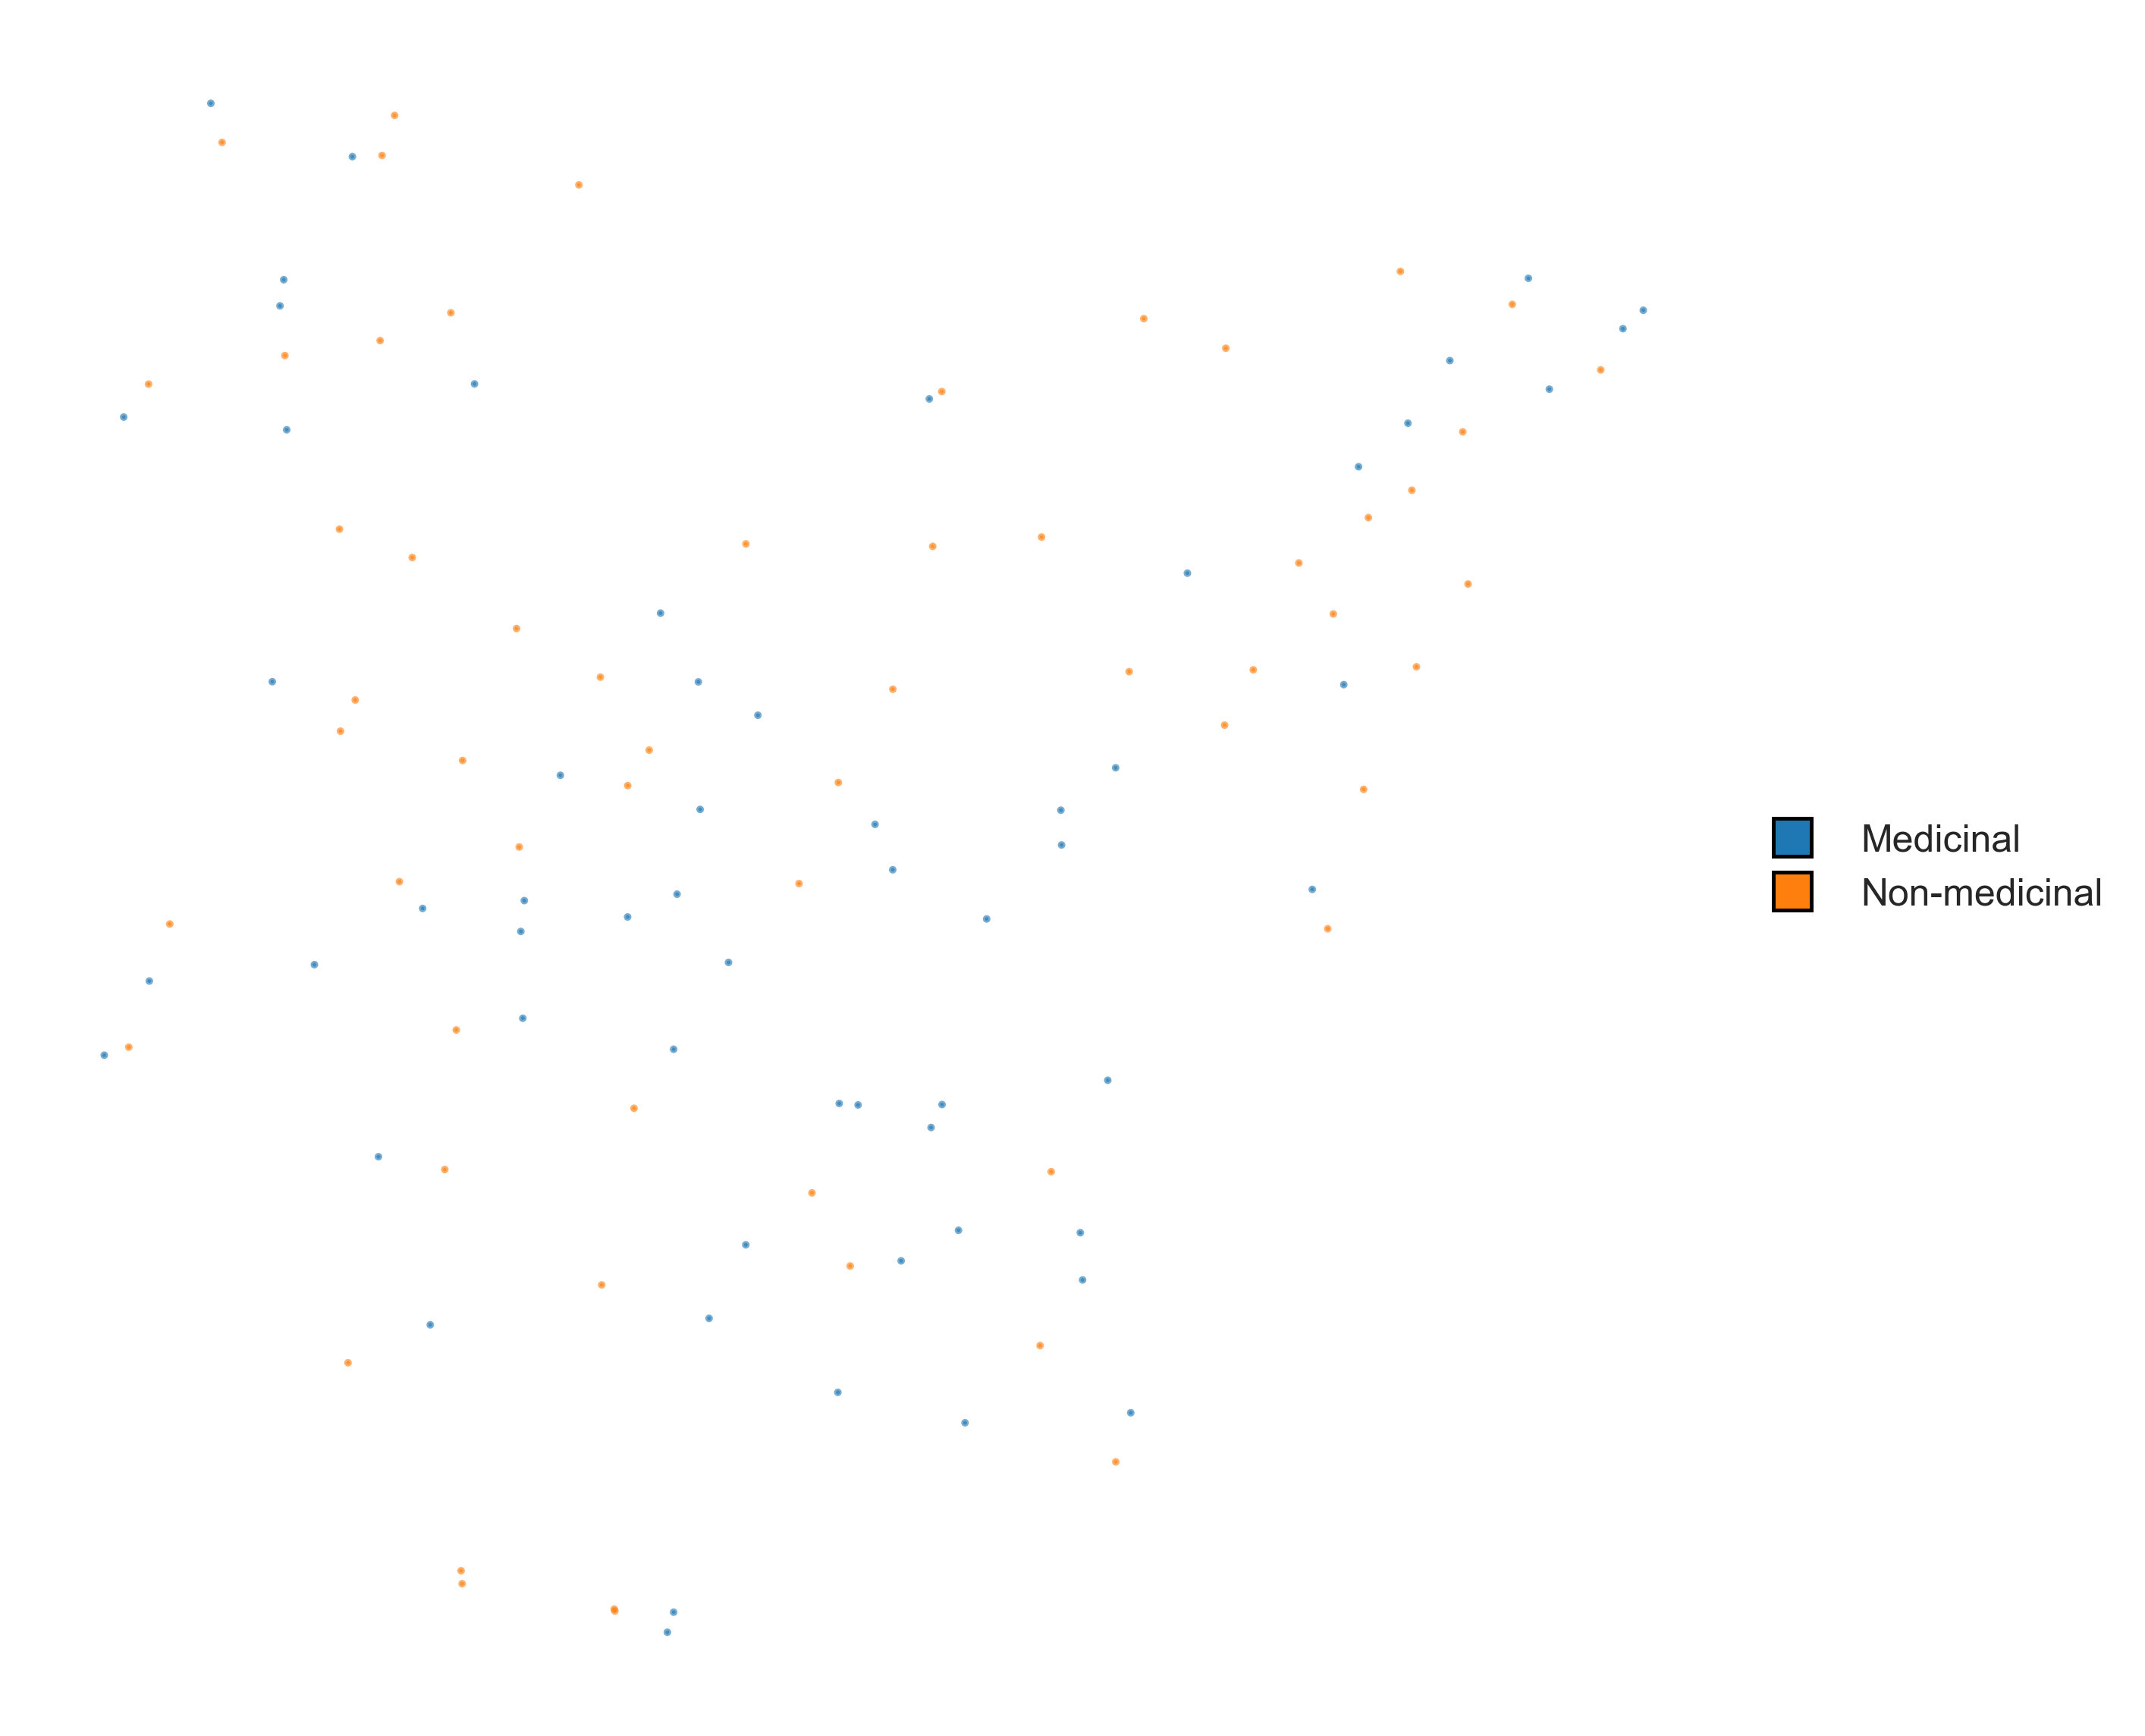

In [54]:
plot(classyfire_embedding_train, classyfire_family_df.index.get_level_values('ftype'))

In [55]:
np_classifier_embedding_train = tsne.fit(np_classifier_family_df)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.3922, 50 iterations in 0.1791 sec
Iteration  100, KL divergence 2.3894, 50 iterations in 0.1367 sec
Iteration  150, KL divergence 2.4086, 50 iterations in 0.1352 sec
Iteration  200, KL divergence 2.3844, 50 iterations in 0.1366 sec
Iteration  250, KL divergence 2.5612, 50 iterations in 0.1350 sec
   --> Time elapsed: 0.72 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

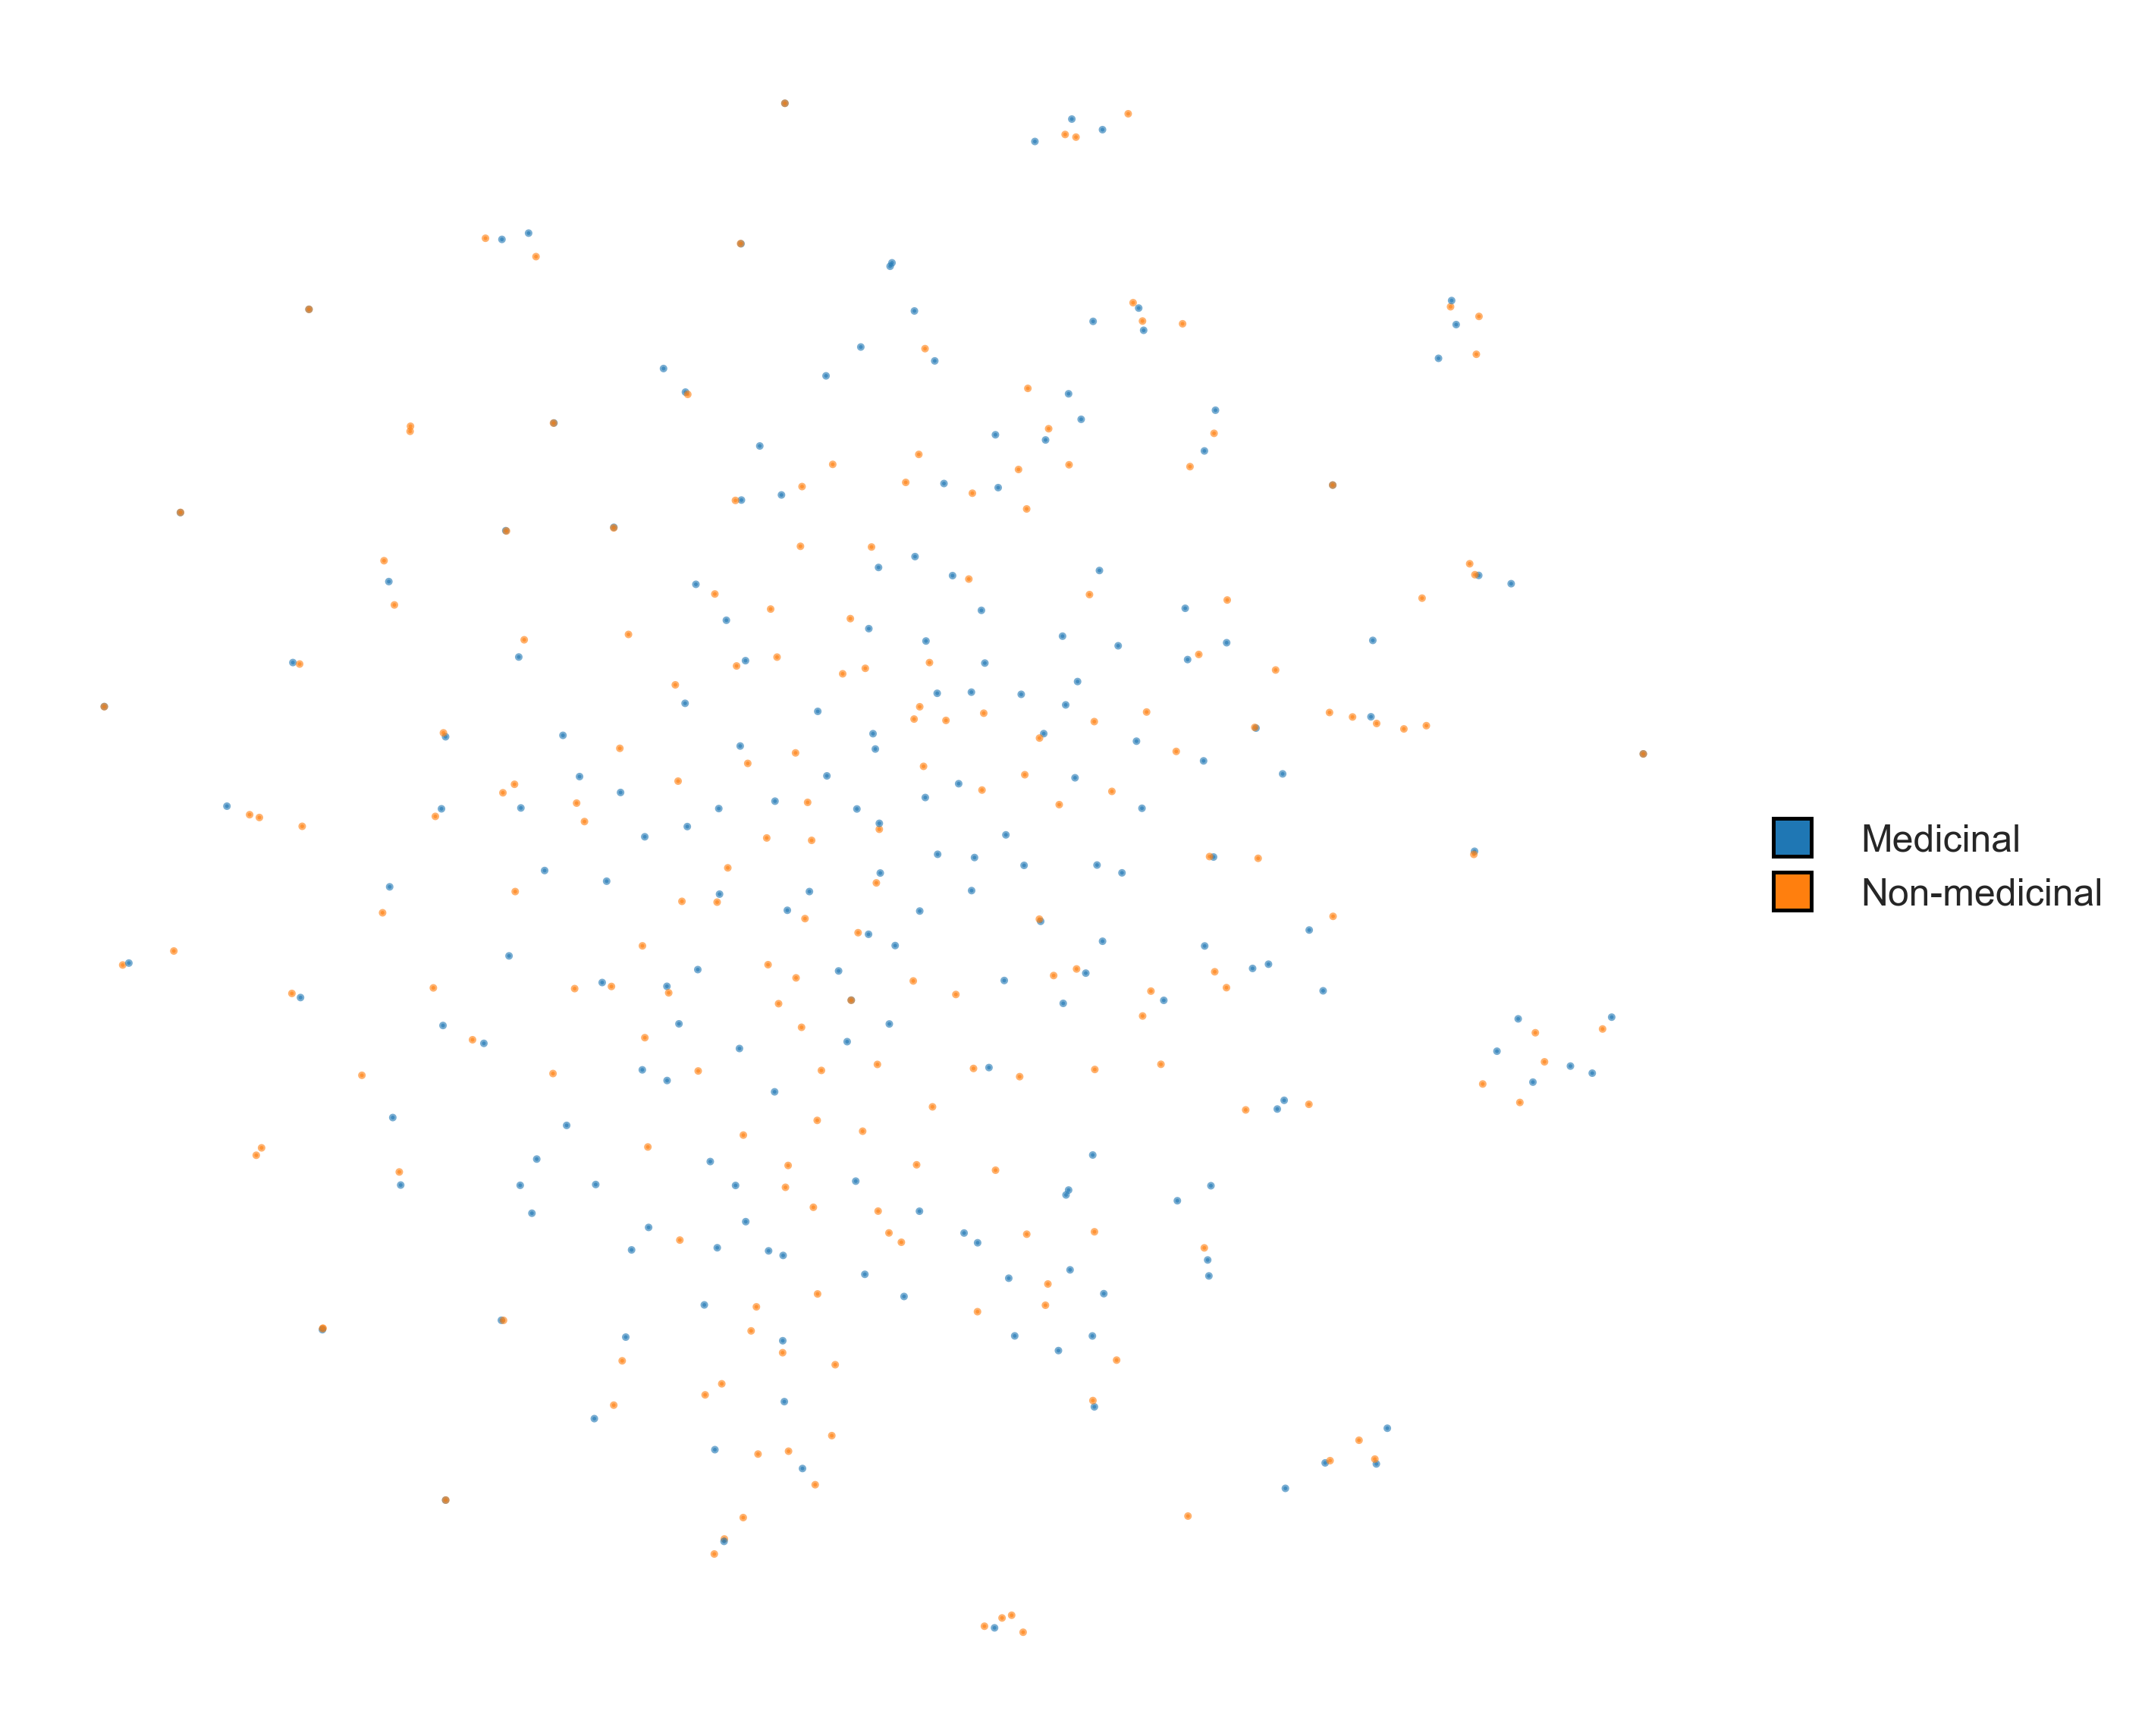

In [56]:
plot(np_classifier_embedding_train, np_classifier_family_df.index.get_level_values('ftype'))

### PCA plot

In [57]:
pca = PCA(n_components=2)

In [58]:
classyfire_components = pca.fit_transform(classyfire_family_df)

principal_classyfire_df = pd.DataFrame(
    data = classyfire_components, 
    columns = ['PC1', 'PC2',] #'PC3']
)
principal_classyfire_df['Type'] = classyfire_family_df.index.get_level_values('ftype')

In [59]:
pca.explained_variance_ratio_

array([0.38426297, 0.23215989])

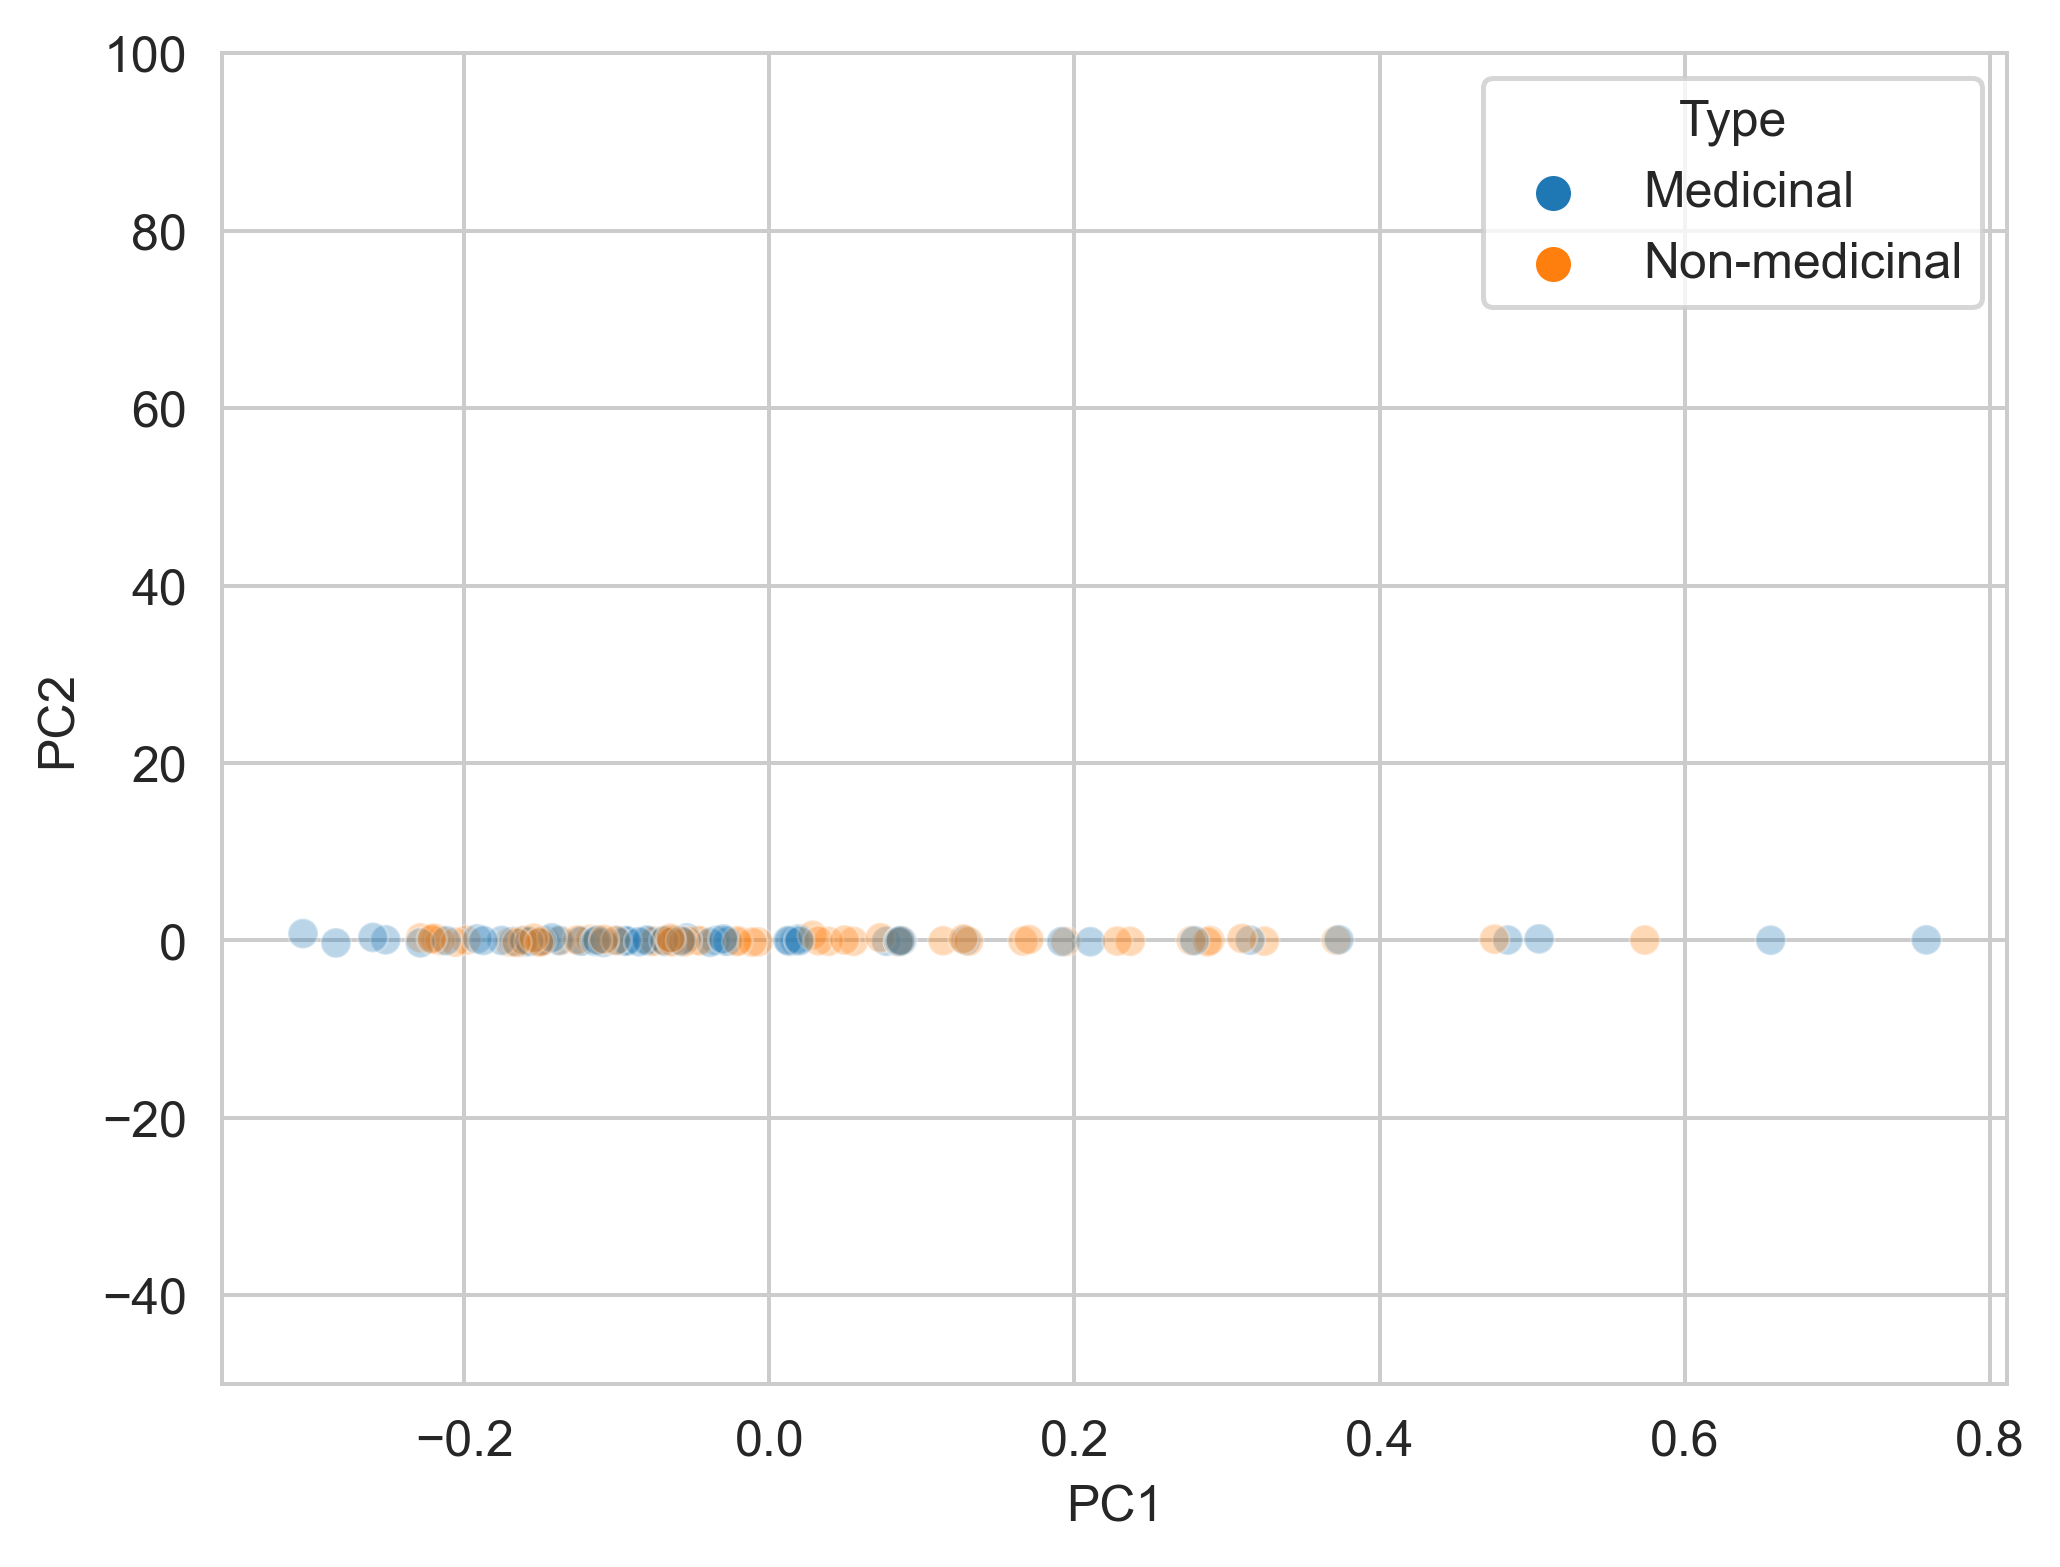

In [60]:
sns.scatterplot(
    data=principal_classyfire_df,
    x='PC1',
    y='PC2',
    hue='Type',
    alpha=0.3
)
plt.ylim(-50, 100)
plt.show()

In [61]:
pca_npclassifire = PCA(n_components=2)
npclassifier_components = pca_npclassifire.fit_transform(np_classifier_family_df)

principal_npclassifier_df = pd.DataFrame(
    data = npclassifier_components, 
    columns = ['PC1', 'PC2']
)
principal_npclassifier_df['Type'] = np_classifier_family_df.index.get_level_values('ftype')

In [62]:
pca_npclassifire.explained_variance_ratio_

array([0.12219454, 0.06758095])

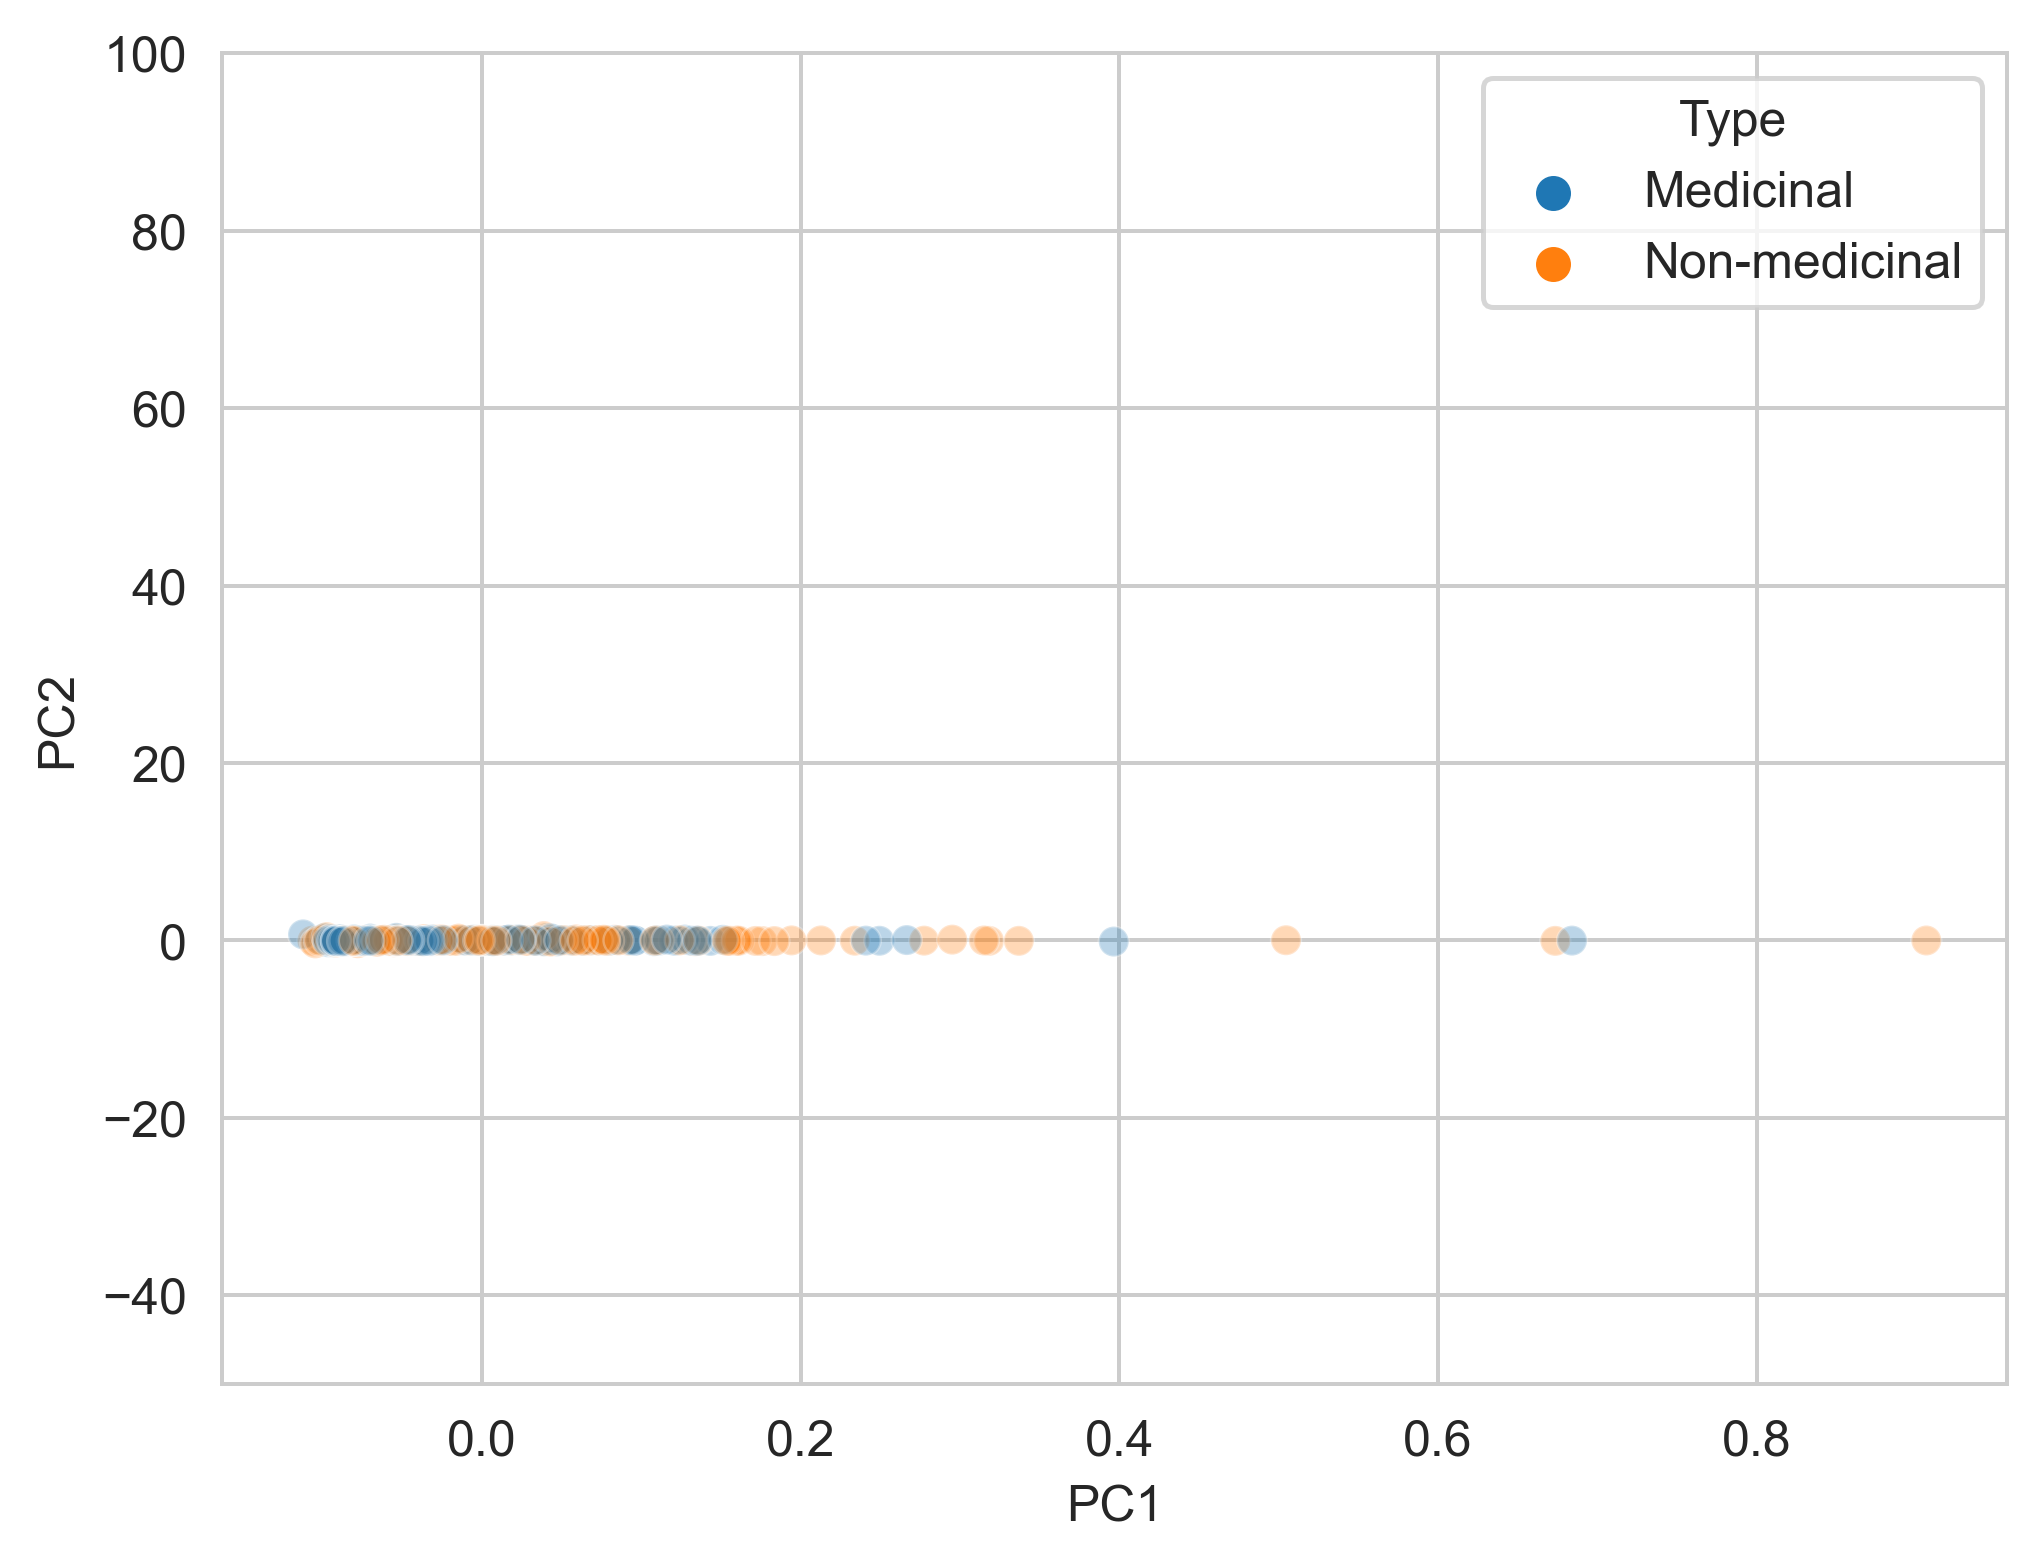

In [63]:
sns.scatterplot(
    data=principal_npclassifier_df,
    x='PC1',
    y='PC2',
    hue='Type',
    alpha=0.3
)
plt.ylim(-50, 100)
plt.show()